In [2]:
''' Import packages. '''
# Time packages
import calendar, cftime, datetime, time
# Numerical analysis packages
import numpy as np, random, scipy, numba
# Local data storage packages
import functools, importlib, os, pickle, collections, sys
import pandas as pd, xarray as xr, nc_time_axis
xr.set_options(keep_attrs=True)
# Visualization tools
import cartopy, cartopy.crs as ccrs, matplotlib, matplotlib.pyplot as plt

# Local imports
sys.path.insert(1, '/projects/GEOCLIM/gr7610/scripts')
import derived, utilities, visualization, track_TCs, zonal_mean
importlib.reload(track_TCs);
importlib.reload(utilities);
importlib.reload(visualization);
importlib.reload(derived);

In [3]:
def get_experiment_set(configurations: dict,
                       field_names: str|list[str],
                       pressure_level: int=500,
                       data_type: str='atmos_month',
                       time_average: bool=True) -> dict:

    ''' 
    Method to load data for a pair of experiments and their difference. 
    Returns a dictionary of time-mean data with the difference of the configurations provided.
    
    `configurations` is defined in the structure of: 
    {<CONFIGURATION_NAME>: {'model_name': <MODEL_NAME>, 'experiment_name': <EXPERIMENT_NAME>}
    '''

    diagnostic_tag = '[get_experiment_set]'
    
    datasets, experiment_names, configuration_names = {}, [], []
    min_year, max_year = 2, 125

    # Perform intake controls
    if isinstance(field_names, str):
        field_names = [field_names]
    assert len(configurations) == 2, 'Only a pair of configurations can be handled at a time.'

    # Iterate through each configuration
    for configuration_name in configurations.keys():

        print(f'{diagnostic_tag} processing configuration {configuration_name}...')

        model_name, experiment_name = [configurations[configuration_name]['model_name'],
                                       configurations[configuration_name]['experiment_name']]
        configuration_names.append(configuration_name)
        experiment_names.append(experiment_name)

        dirname = f'/scratch/gpfs/GEOCLIM/gr7610/tiger3/{model_name}/work/{experiment_name}_tiger3_intelmpi_24_540PE/POSTP'

        # Obtain pathnames matching the iterand criteria
        pathnames = [f'{dirname}/{year:04d}0101.{data_type}.nc' for year in range(min_year, max_year)]
        pathnames = [pathname for pathname in pathnames if pathname.split('/')[-1] in os.listdir(dirname)]

        # Pull data
        datasets[configuration_name] = xr.open_mfdataset(pathnames)[field_names]
        # Find matching pressure level if requested, else load planar data
        # Obtain time-mean
        if 'pfull' in datasets[configuration_name].dims:
            datasets[configuration_name] = datasets[configuration_name].sel(pfull=pressure_level, 
                                                                            method='nearest').load()
        else:
            datasets[configuration_name] = datasets[configuration_name].load()
        # Apply time-averaging, if chosen
        if time_average:
            datasets[configuration_name] = datasets[configuration_name].mean('time')
        # Adjust values based on field name (for example, precipitation and evaporation should be 
        # multiplied by 86400 to convert kg/m^2/s to mm/d)
        datasets[configuration_name] = utilities.field_correction(data=datasets[configuration_name])
        # Apply latitude weighting
        # datasets[configuration_name] = datasets[configuration_name].weighted(np.cos(np.deg2rad(datasets[configuration_name].grid_yt))).mean('grid_xt')


    # Load data
    meridional_extent = slice(-90, 90)
    difference = (datasets[configuration_names[0]] - datasets[configuration_names[1]]).sel(grid_yt=meridional_extent)

    difference_configuration_name = f'DIFF.{configuration_names[0]}-{configuration_names[1]}'
    datasets[difference_configuration_name] = difference

    return datasets

In [4]:
def load(model_names: str|list[str],
         experiment_names: str|list[str],
         field_name: str='t_surf') -> dict:

    ''' Method to load SST data from a combination of the provided models and experiments. '''
    if isinstance(model_names, str): model_names = [model_names]
    if isinstance(experiment_names, str): experiment_names = [experiment_names]

    # Initialize SST container dictionary
    OUT = {}
    # Iterate through configurations to load SST data
    for model_name in model_names:
        for experiment_name in experiment_names:
            
            configurations = {'CTL': {'model_name': model_name,
                                      'experiment_name': f'CTL1990.{experiment_name}',
                                      'npes': 540},
                              'EXP': {'model_name': model_name,
                                      'experiment_name': f'CTL1990_SWISHE.{experiment_name}',
                                      'npes': 540},}
            
            TMP = get_experiment_set(configurations=configurations, 
                                     pressure_level=500,
                                     field_names=[field_name],
                                     time_average=False)
        
            TMP = {f'{model_name}:{experiment_name}:{k}': v for k, v in TMP.items()}
            OUT.update(TMP)

    return OUT

In [5]:
def plot_zonal_mean(TMP: dict,
                     model_name: str='HIRAM',
                     field_name: str='t_surf',
                     savefig: bool=False):

    ''' Generates figure of zonal mean data of the provided configurations with an option to save. '''

    rolling_degrees = 10
    factor = 100 if field_name in ['swfq'] else 1
    experiment_type = 'CTL' if field_name == 't_surf' else 'EXP'
    # Pare down the data to use for plotting SSTs
    config_names = [config_name for config_name in TMP.keys() 
                    if config_name.split(':')[-1] == experiment_type and
                    config_name.split(':')[0] == 'HIRAM']
    
    # Define colors to use
    colors = visualization.get_colormap_samples(number_of_samples=len(config_names),
                                                colormap_name='viridis', 
                                                interval_minimum=0.1, interval_maximum=0.9)

    # Initialize figure
    dpi = 300 if savefig else 144
    fig, ax = plt.subplots(figsize=(2, 3), dpi=dpi)
    
    ax.axhline(0, c='k', lw=0.5, ls='--')
    for index, config_name in enumerate(config_names):
        mean, std = TMP[config_name][field_name].mean(['grid_xt', 'time']), TMP[config_name][field_name].std(['grid_xt', 'time'])

        if field_name != 't_surf': mean = mean.rolling(grid_yt=(rolling_degrees * 2), center='True').mean()
        
        label = f"{config_name.split(':')[1]}"
    
        if field_name == 't_surf': ax.fill_betweenx(y=mean.grid_yt, x1=mean-std, x2=mean+std, alpha=0.2, fc=colors[index])
        ax.plot(mean * factor, mean.grid_yt, c=colors[index], label=label)
        
    ax.set_yticks(np.arange(-90, 90 + 30, 30))
    ax.set_ylim([-90 + rolling_degrees, 90 - rolling_degrees])
    ax.set_ylabel('Latitude', labelpad=10)

    long_name, units = visualization.field_properties(field_name)
    long_name = zonal_mean.get_field_name_alias(field_name)
    ax.set_xlabel(f'{long_name} [{units}]', labelpad=10)
    
    fig.tight_layout()
    fig.legend(bbox_to_anchor=(1, 0.975), loc='upper left', frameon=False, fontsize=9)

    # Save the figure, if the option is chosen
    storage_dirname = '/tigress/GEOCLIM/gr7610/analysis/TC-AQP/figs'
    storage_filename = f'zonal_mean_SST-{model_name}.pdf'
    if savefig:
        plt.savefig(os.path.join(storage_dirname, storage_filename),
                    dpi=dpi,
                    format='pdf',
                    bbox_inches='tight')

In [42]:
def plot_zonal_mean_SWISHE(TMP: dict,
                           model_names: list[str]=['AM2.5', 'HIRAM'],
                           field_name: str='swfq',
                           savefig: bool=False):

    ''' Generates figure of zonal mean data of the provided configurations with an option to save. '''

    rolling_degrees = 10
    factor = 100 if field_name in ['swfq'] else 1
    
    experiment_type = 'CTL' if field_name == 't_surf' else 'EXP'
    
    # Pare down the data to use for plotting SSTs
    config_names = [config_name for config_name in TMP.keys() 
                    if config_name.split(':')[-1] == experiment_type]
    

    # Initialize figure
    dpi = 300 if savefig else 144
    fig, gs = plt.figure(figsize=(6, 2.5), dpi=dpi), matplotlib.gridspec.GridSpec(nrows=1, ncols=len(model_names)) 

    # Iterate over models (corresponding to columns)
    for index in range(gs.ncols):
        # Initialize subplot axis
        ax = fig.add_subplot(gs[0, index])
        ax.axhline(0, c='k', lw=0.5, ls='--')

        # Get model-specific configurations
        subconfig_names = [name for name in config_names if model_names[index] in name]
        
        # Define colors to use
        colors = visualization.get_colormap_samples(number_of_samples=len(subconfig_names),
                                                    colormap_name='managua', 
                                                    interval_minimum=0.1, interval_maximum=0.9)
        # Iterate over subconfigurations
        for subindex, subconfig_name in enumerate(subconfig_names):
            model_name, experiment_name = [subconfig_name.split(':')[0], 
                                           f'CTL1990.{subconfig_name.split(':')[1]}']
            # print(f'Configuration name: {subconfig_name}; model name: {model_name}; experiment name: {experiment_name}')
            
            mean = TMP[subconfig_name][field_name].mean(['grid_xt', 'time'])
            if field_name != 't_surf': mean = mean.rolling(grid_yt=(rolling_degrees * 2), center='True').mean()
            
            label = f"{subconfig_name.split(':')[1]}" if index == 0 else '_nolegend_'
            ax.plot(mean.grid_yt, mean * factor, c=colors[subindex], lw=2, label=label)

            visualization.TC_density_histogram(ax=ax,
                                               model_name=model_name,
                                               experiment_names=[experiment_name],
                                               bin_size=5,
                                               axis_depth=0.2,
                                               orientation='vertical',
                                               basin_name=None,
                                               colors=[colors[subindex]],
                                               diagnostic=False)
            
        # Apply subplot labeling
        ax.set_title(f'{visualization.get_alphabet_letter(index)}) {model_names[index]}', fontsize=11)
        ax.set_xticks(np.arange(-90, 90 + 30, 30))
        ax.set_xlim([-90 + rolling_degrees, 90 - rolling_degrees])
        ax.set_yticks(np.arange(0, 6))
        ax.set_ylim([0, 5])

        # Ensure the axis spines stay above all other elements
        for k, spine in ax.spines.items():
            spine.set_zorder(100)
        
    fig.tight_layout()

    # Apply labeling
    long_name, units = visualization.field_properties(field_name)
    long_name = zonal_mean.get_field_name_alias(field_name)
    fig.supylabel(f'{long_name}\n[{units}]', fontsize=11, x=-0.025, y=0.45, ha='right')
    fig.supxlabel('Latitude', fontsize=11, y=-0.05)
    
    fig.legend(bbox_to_anchor=(1, 0.75), loc='upper left', frameon=False, fontsize=9)

    # Save the figure, if the option is chosen
    storage_dirname = '/tigress/GEOCLIM/gr7610/analysis/TC-AQP/figs'
    storage_filename = f'zonal_mean-SWISHE_frequency.pdf'
    if savefig:
        plt.savefig(os.path.join(storage_dirname, storage_filename),
                    dpi=dpi,
                    format='pdf',
                    bbox_inches='tight')

In [7]:
def plot_SST_hierarchy(SST: dict,
                       model_name: str='HIRAM',
                       diagnostic: bool=False,
                       savefig: bool=False):

    ''' Plot SSTs for the model hierarchy. '''

    # Helper function to determine colormap bounds
    cmap_trunc = lambda cmap, a, b: matplotlib.colors.LinearSegmentedColormap.from_list(f'trunc({cmap.name},{a:.2f},{b:.2f})', 
                                                                                        cmap(np.linspace(a, b, 256)))

    # Format normalization and colormap parameters
    cmap = cmap_trunc(matplotlib.pyplot.get_cmap('plasma'), 0.25, 0.95)
    bounds = np.arange(273, 305, 2)
    norm = matplotlib.colors.BoundaryNorm(bounds, 256)
    
    # Pare down the data to use for plotting SSTs
    config_names_SST = [config_name for config_name in SST.keys() 
                        if config_name.split(':')[-1] == 'CTL' and
                        config_name.split(':')[0] == 'HIRAM']

    projection, reference_projection = ccrs.Mollweide(central_longitude=180), ccrs.PlateCarree()
    
    ax_width = 1.75
    ncols, nrows = 2 * 3, 2
    dpi = 300 if savefig else 144
    fig, gs = [plt.figure(figsize=(ax_width * ncols, ax_width * nrows), dpi=dpi),
               matplotlib.gridspec.GridSpec(nrows=nrows, ncols=ncols+1, width_ratios=[1]*6 + [0.1])]
    
    axes = {}
    for config_index, config_name in enumerate(config_names_SST):
        nrow = config_index // 3
        ncol = config_index % 3
        width_ncols, offset_ncols = 2, nrow
        start_ncol, end_ncol = 2 * ncol + offset_ncols, 2 * ncol + width_ncols + offset_ncols
    
        if diagnostic:
            print(f'Iterand configuration index: {config_index}; name: {config_name}')
            print(f'\trow number: {nrow}; col number: {ncol}; offset: {offset_ncols}')
            print(f'\tcolumn span range: {start_ncol, end_ncol}')
        
        ax = fig.add_subplot(gs[nrow, start_ncol:end_ncol],
                             projection=projection)
    
        SST_TMP = utilities.land_mask(SST[config_name]['t_surf'].mean('time')) if 'AMIP' in config_name else SST[config_name]['t_surf'].mean('time')
        
        im = ax.contourf(SST[config_name].grid_xt, SST[config_name].grid_yt, SST_TMP,
                         transform=reference_projection, norm=norm, cmap=cmap, levels=len(bounds))
        
        ax.axhline(0, c='k', lw=0.5, ls='--')
    
        if 'AMIP' in config_name: 
            ax.coastlines(lw=0.5)
            ax.add_feature(cartopy.feature.LAND, fc=(0.9, 0.9, 0.9))
            
        title_str = f"{visualization.get_alphabet_letter(config_index)}) {config_name.split(':')[1]}"
        ax.set_title(title_str, fontsize=11, loc='left', va='top', ha='left')
        
        axes[config_name] = {'ax': ax, 'im': im}
    
    cax = fig.add_subplot(gs[:, -1])
    colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, extend='both')
    colorbar.set_label('Sea-surface temperature [K]', rotation=270, labelpad=20)
    
    fig.tight_layout()
    
    # Save the figure, if the option is chosen
    storage_dirname = '/tigress/GEOCLIM/gr7610/analysis/TC-AQP/figs'
    storage_filename = f'model_hierarchy_SSTs-{model_name}.pdf'
    if savefig:
        plt.savefig(os.path.join(storage_dirname, storage_filename),
                    dpi=dpi,
                    format='pdf',
                    bbox_inches='tight')

### Generate plots

#### Generate SWISHE zonal means

In [8]:
model_names = ['AM2.5', 'HIRAM']
experiment_names = ['CONST', '0N', '15N', 'TIMEVAR', 'AMIP']
field_name = 'swfq'

In [9]:
SWFQ = load(model_names=model_names, experiment_names=experiment_names, field_name=field_name)

[get_experiment_set] processing configuration CTL...
[get_experiment_set] processing configuration EXP...
[get_experiment_set] processing configuration CTL...
[get_experiment_set] processing configuration EXP...
[get_experiment_set] processing configuration CTL...
[get_experiment_set] processing configuration EXP...
[get_experiment_set] processing configuration CTL...
[get_experiment_set] processing configuration EXP...
[get_experiment_set] processing configuration CTL...
[get_experiment_set] processing configuration EXP...
[get_experiment_set] processing configuration CTL...
[get_experiment_set] processing configuration EXP...
[get_experiment_set] processing configuration CTL...
[get_experiment_set] processing configuration EXP...
[get_experiment_set] processing configuration CTL...
[get_experiment_set] processing configuration EXP...
[get_experiment_set] processing configuration CTL...
[get_experiment_set] processing configuration EXP...
[get_experiment_set] processing configuration 

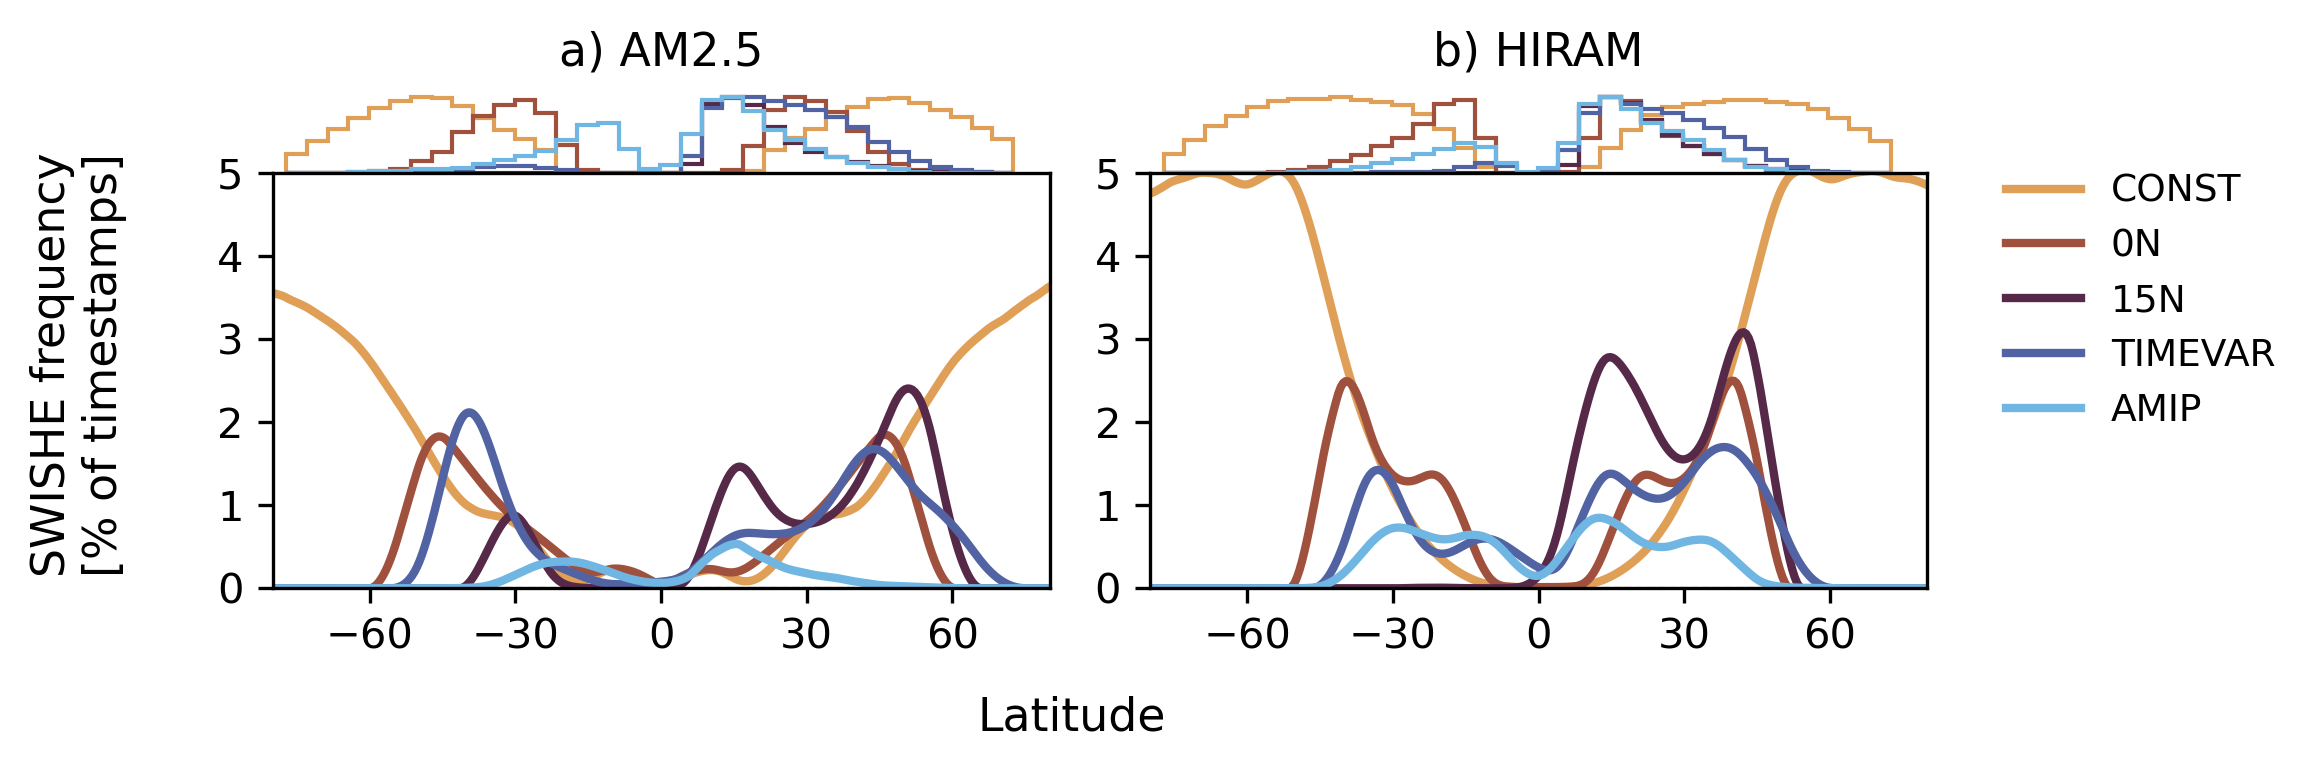

In [43]:
importlib.reload(zonal_mean)
plot_zonal_mean_SWISHE(TMP=SWFQ, model_names=model_names, field_name='swfq', savefig=True)

#### Generate zonal mean SSTs

In [58]:
model_names = ['AM2.5', 'HIRAM']
experiment_names = ['CONST', '0N', '15N', 'TIMEVAR', 'AMIP']
field_name = 't_surf'

In [ ]:
SST = load(model_names=model_names, experiment_names=experiment_names, field_name=field_name)

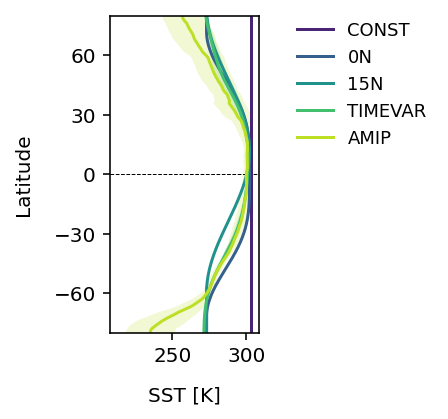

In [60]:
importlib.reload(zonal_mean)
plot_zonal_mean(TMP=SST, field_name='t_surf', savefig=False)

#### Generate 2D SST hierarchy

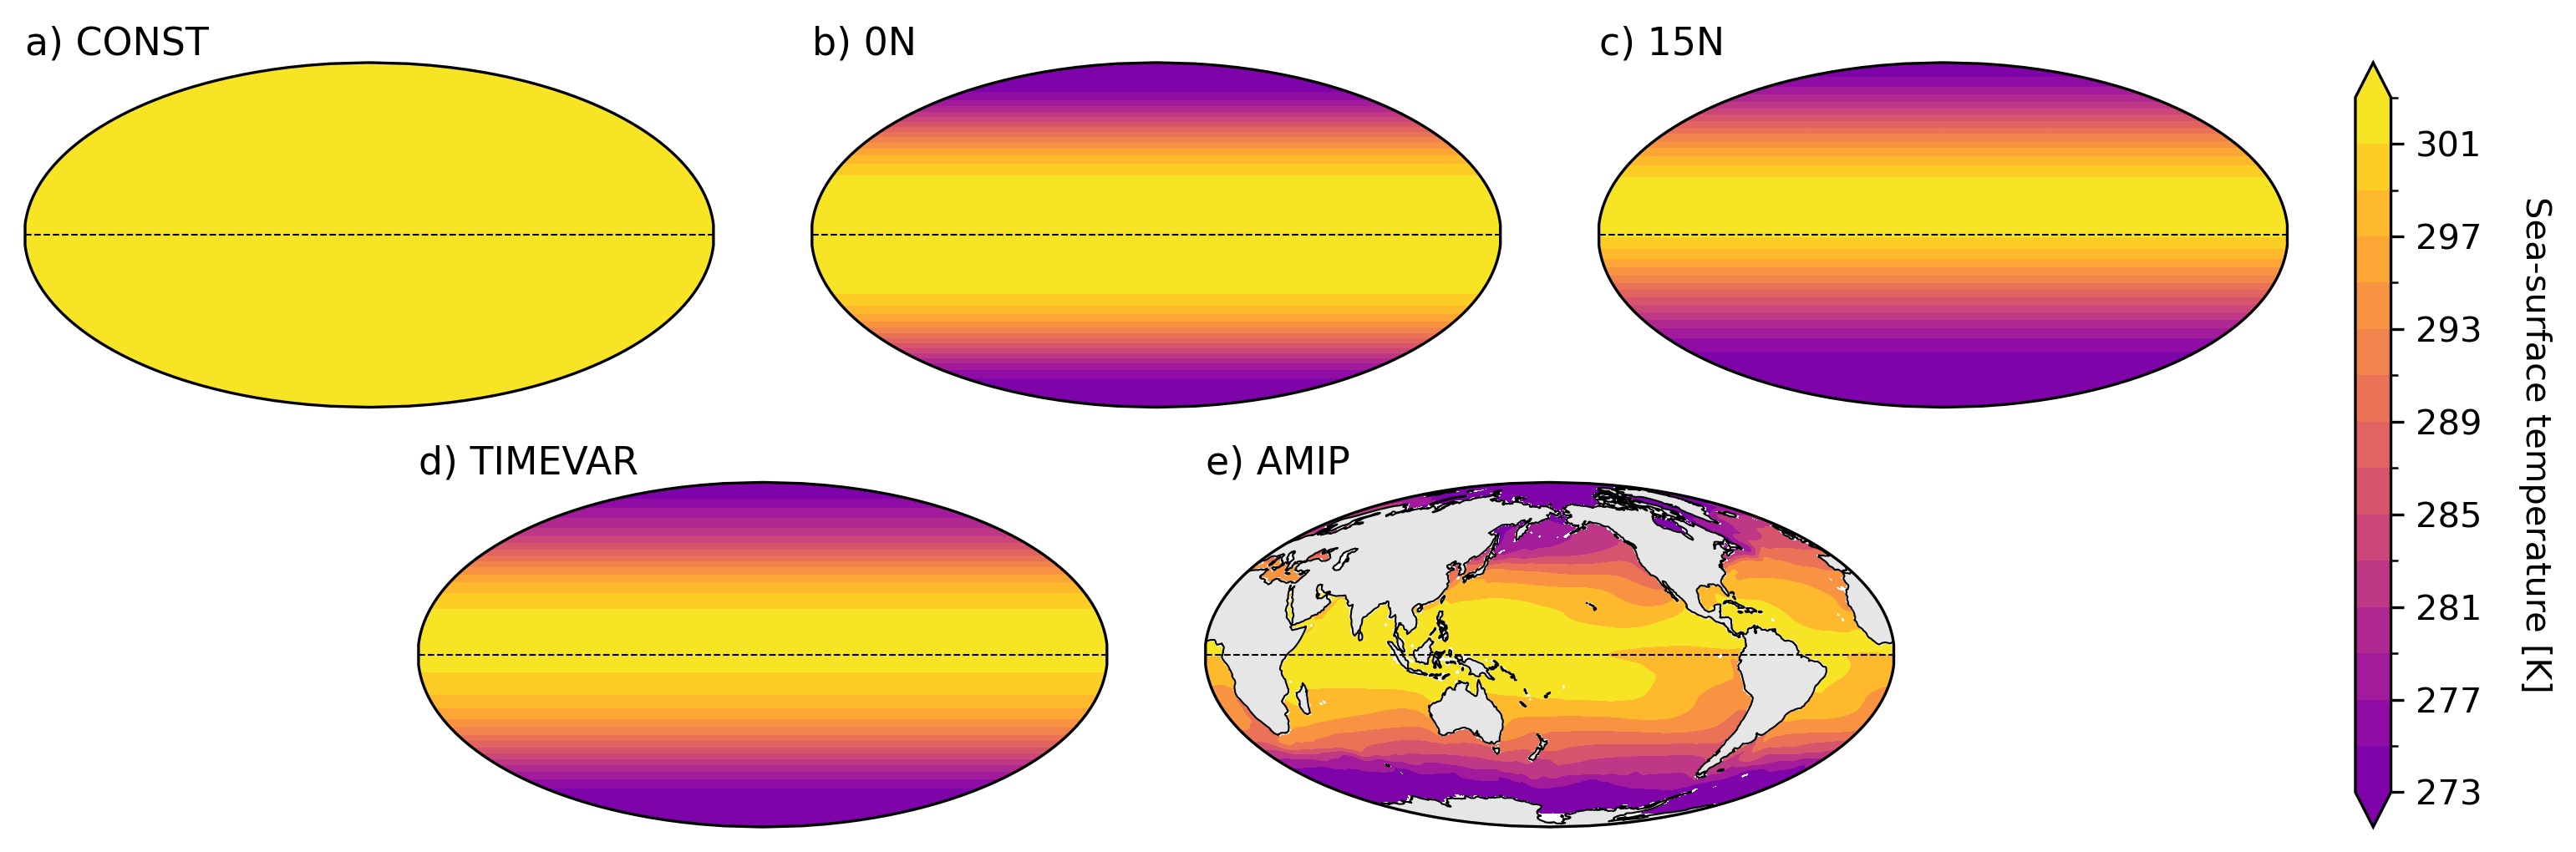

In [12]:
plot_SST_hierarchy(SST=SST, savefig=True)